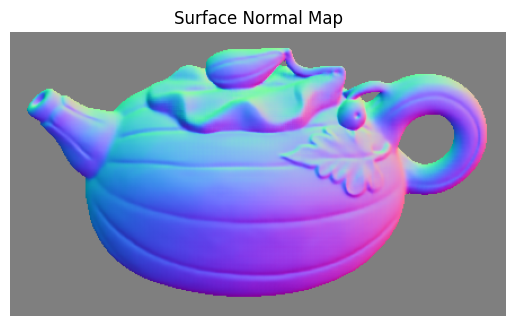

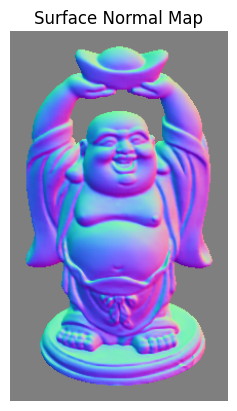

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_normal_npy(npy_path):
    # Load the [3, H, W] normal map
    normals = np.load(npy_path)  
    normal_vis = (normals + 1) / 2  
    normal_vis = np.transpose(normal_vis, (1, 2, 0))  

    plt.imshow(normal_vis)
    plt.title("Surface Normal Map")
    plt.axis("off")
    plt.show()


visualize_normal_npy('./shagoto_predicted_normal/normal_shagoto2.npy')
visualize_normal_npy('./shagoto_predicted_normal/normal_shagoto5.npy')


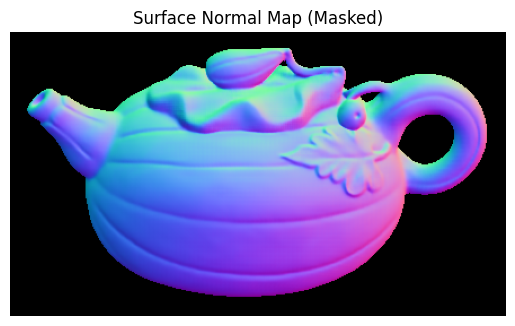

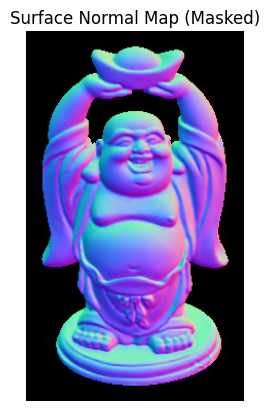

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def visualize_normal_npy_with_mask(npy_path, mask_path):
    # Load the [3, H, W] normal map
    normals = np.load(npy_path)  # shape: (3, H, W)
    normal_vis = (normals + 1) / 2  # normalize to [0, 1]
    
    # Transpose to (H, W, 3)
    normal_vis = np.transpose(normal_vis, (1, 2, 0))

    mask = np.array(Image.open(mask_path).convert("L"))  # shape: (H, W)
    mask = mask > 0  # binary mask: True where valid
    
    # Apply mask: set background pixels to black
    normal_vis[~mask] = 0

    # Visualize
    plt.imshow(normal_vis)
    plt.title("Surface Normal Map (Masked)")
    plt.axis("off")
    plt.show()


mask_path = "../SDPS-Net/data/datasets/DiLiGenT/pmsData_crop/pot1PNG/mask.png"
visualize_normal_npy_with_mask('./shagoto_predicted_normal/normal_shagoto2.npy', mask_path)
mask_path = "../SDPS-Net/data/datasets/DiLiGenT/pmsData_crop/buddhaPNG/mask.png"
visualize_normal_npy_with_mask('./shagoto_predicted_normal/normal_shagoto5.npy', mask_path)


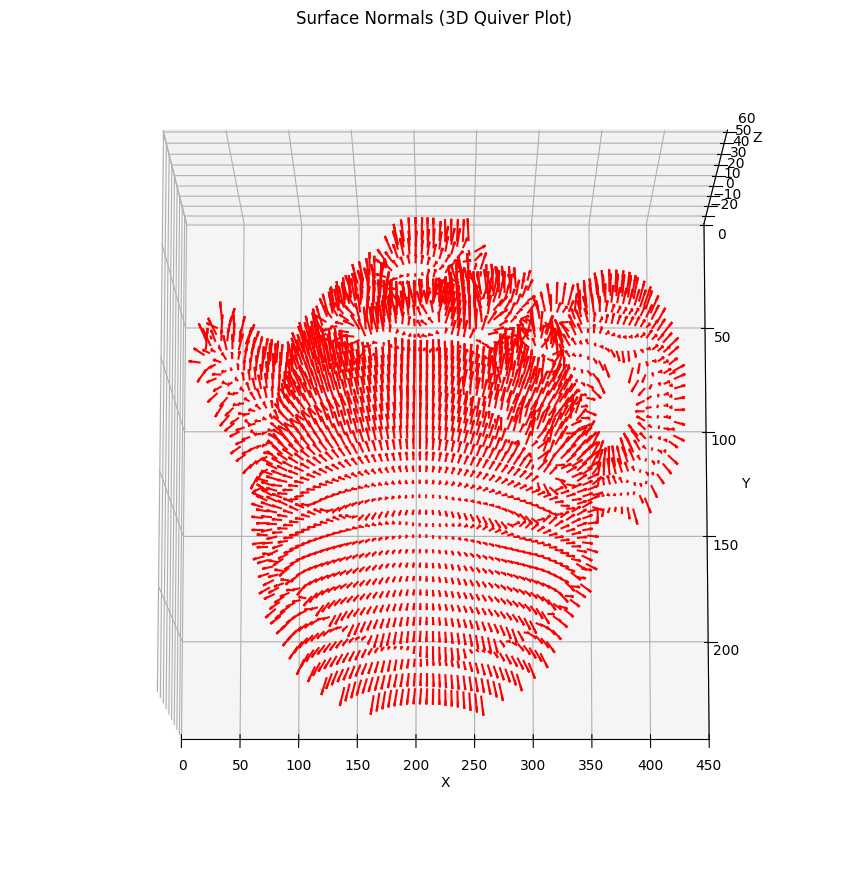

Saved mesh: ./shagoto_predicted_mesh/pot_SDPS.ply


In [17]:
import os
import cv2
import numpy as np
import open3d as o3d
from numpy.fft import fft2, ifft2

def frankot_chellappa(p, q):
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T

    Px = fft2(p)
    Qy = fft2(q)

    denom = (2 * np.pi * wx) ** 2 + (2 * np.pi * wy) ** 2
    denom[0, 0] = 1  

    Z = (-1j*2*np.pi*wx * Px - 1j*2*np.pi*wy * Qy) / denom
    return np.real(ifft2(Z))

def depth_from_normals(normals):
    nz = normals[:, :, 2].copy()
    nz[nz == 0] = 1e-6  

    p = -normals[:, :, 0] / nz
    q = -normals[:, :, 1] / nz
    return frankot_chellappa(p, q)

def save_mesh(depth, normals, out_ply):
    h, w = depth.shape
    # Create XY grid
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    pts = np.stack([xx, yy, depth], axis=-1).reshape(-1, 3)
    norms = normals.reshape(-1, 3)

    mag = np.linalg.norm(norms, axis=1)
    mask = mag > 1e-3

    verts  = pts[mask]
    normals = norms[mask]

    pcd = o3d.geometry.PointCloud(
        o3d.utility.Vector3dVector(verts)
    )
    pcd.normals = o3d.utility.Vector3dVector(normals)
    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)

    # Ball Pivoting
    dists = np.asarray(pcd.compute_nearest_neighbor_distance())
    avg   = dists.mean()
    radii = [avg*2, avg*4]
    mesh  = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector(radii)
    )
    o3d.io.write_triangle_mesh(out_ply, mesh)
    print(f"Saved mesh: {out_ply}")

if __name__ == "__main__":
    normal_npy = "./shagoto_predicted_normal/normal_shagoto2.npy"
    out_ply    = "./shagoto_predicted_mesh/pot_SDPS.ply"

    # ---- Load normals ----
    normals = np.load(normal_npy)  # shape [3,H,W] or [H,W,3]
    if normals.ndim == 3 and normals.shape[0] == 3:
        normals = normals.transpose(1,2,0)  # -> [H,W,3]
    normals = normals.astype(np.float32)

    normals[:, :, 1] *= -1
    normals[:, :, 2] *= -1


    # ---- Integrate depth ----
    depth = depth_from_normals(normals)

    # Extract height and width
    mask_path = os.path.join("./data/datasets/DiLiGenT/pmsData_crop/pot1PNG/", "mask.png")
    mask = cv2.imread(mask_path, 0)
    mask = (mask > 0) 
    H, W = depth.shape
    normal_map=normals
    # Extract normals
    Nx = normal_map[:, :, 0]
    Ny = normal_map[:, :, 1]
    Nz = normal_map[:, :, 2]
    
    # Create grid of (X,Y) pixel coordinates
    X_coords = np.arange(W)
    Y_coords = np.arange(H)
    X, Y = np.meshgrid(X_coords, Y_coords)
    
    # Downsample for clarity
    step = 5  
    X_plot = X[::step, ::step]
    Y_plot = Y[::step, ::step]
    Z_plot = depth[::step, ::step]
    Nx_plot = Nx[::step, ::step]
    Ny_plot = Ny[::step, ::step]
    Nz_plot = Nz[::step, ::step]
    
   
    Z_plot = -Z_plot
    Nz_plot = -Nz_plot
    
    # Apply mask to remove background points
    mask_small = mask[::step, ::step]
    X_plot = X_plot[mask_small]
    Y_plot = Y_plot[mask_small]
    Z_plot = Z_plot[mask_small]
    Nx_plot = Nx_plot[mask_small]
    Ny_plot = Ny_plot[mask_small]
    Nz_plot = Nz_plot[mask_small]
    
    # Create 3D quiver plot
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(X_plot, Y_plot, Z_plot, Nx_plot, Ny_plot, Nz_plot,
              length=10.0, normalize=True, color='r')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Surface Normals (3D Quiver Plot)')
    ax.view_init(elev=80, azim=90)
    ax.set_xlim(450, 0) 
    plt.tight_layout()
    plt.show()
    save_mesh(depth, normals, out_ply)


#### For color

In [18]:
import os
import numpy as np
import cv2
import open3d as o3d
from numpy.fft import fft2, ifft2

def frankot_chellappa(p, q):
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T
    Px, Qy = fft2(p), fft2(q)
    denom = (2*np.pi*wx)**2 + (2*np.pi*wy)**2
    denom[0,0] = 1
    Z = (-1j*2*np.pi*wx*Px - 1j*2*np.pi*wy*Qy) / denom
    return np.real(ifft2(Z))

def depth_from_normals(normals):
    nz = normals[:,:,2].copy()
    nz[nz==0] = 1e-6
    p = -normals[:,:,0]/nz
    q = -normals[:,:,1]/nz
    return frankot_chellappa(p, q)

def mesh_with_color(normal_npy, color_img_path, out_ply):
    normals = np.load(normal_npy)  # [3,H,W] or [H,W,3]
    if normals.ndim==3 and normals.shape[0]==3:
        normals = normals.transpose(1,2,0)
    normals = normals.astype(np.float32)

    normals[:, :, 1] *= -1
    normals[:, :, 2] *= -1

    depth = depth_from_normals(normals)

    color = cv2.imread(color_img_path, cv2.IMREAD_COLOR)
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    h,w,_ = color.shape

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    pts = np.stack([xx, yy, depth], axis=-1).reshape(-1,3)
    norms = normals.reshape(-1,3)
    cols  = color.reshape(-1,3)

    mask = np.linalg.norm(norms,axis=1)>1e-3
    pts, norms, cols = pts[mask], norms[mask], cols[mask]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    pcd.normals= o3d.utility.Vector3dVector(norms)
    pcd.colors = o3d.utility.Vector3dVector(cols)

    # 5) mesh via BallPivoting
    pcd.estimate_normals()
    dists = np.asarray(pcd.compute_nearest_neighbor_distance())
    avg   = dists.mean()
    radii = [avg*2, avg*4]
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector(radii)
    )

    # 6) transfer colors from pcd → mesh vertices via nearest‐neighbor
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    mesh_vert = np.asarray(mesh.vertices)
    mesh_colors = []
    for v in mesh_vert:
        _, idx, _ = pcd_tree.search_knn_vector_3d(v, 1)
        mesh_colors.append(np.asarray(pcd.colors)[idx[0]])
    mesh.vertex_colors = o3d.utility.Vector3dVector(np.vstack(mesh_colors))

    # 7) save
    os.makedirs(os.path.dirname(out_ply), exist_ok=True)
    o3d.io.write_triangle_mesh(out_ply, mesh)
    print(f"Saved colored mesh to {out_ply}")

if __name__ == "__main__":
    color_img = "./data/datasets/DiLiGenT/pmsData_crop/pot1PNG/001.png"
    mesh_with_color(
      normal_npy = "./shagoto_predicted_normal/normal_shagoto2.npy",
      color_img_path = color_img,
      out_ply = "./shagoto_predicted_mesh/pot_colored_SDPS.ply"
    )


Saved colored mesh to ./shagoto_predicted_mesh/pot_colored_SDPS.ply


#### Angular Error

In [19]:
import scipy.io
import numpy as np
import os


normal_gt_path = os.path.join("./data/datasets/DiLiGenT/pmsData_crop/pot1PNG/", "Normal_gt.mat")
mat = scipy.io.loadmat(normal_gt_path)
normal_gt = mat['Normal_gt']  

normal_gt[:, :, 1] *= -1
normal_gt[:, :, 2] *= -1

norm_pred = normal_map / (np.linalg.norm(normal_map, axis=2, keepdims=True) + 1e-6)
norm_gt = normal_gt / (np.linalg.norm(normal_gt, axis=2, keepdims=True) + 1e-6)

dot_product = np.sum(norm_pred * norm_gt, axis=2)
dot_product = np.clip(dot_product, -1.0, 1.0)  # Clamp for safety

angular_error = np.arccos(dot_product) * (180.0 / np.pi)

angular_error[~mask] = np.nan

mean_angular_error = np.nanmean(angular_error)
print(f"Mean Angular Error: {mean_angular_error:.2f} degrees")


Mean Angular Error: 8.14 degrees


#### Mesh
![Mesh Animation.gif](./shagoto_predicted_mesh/ImageToStl.com_pot_SDPS+(3).ply.gif)


#### Mesh Color
![Mesh Animation.gif](./shagoto_predicted_mesh/ImageToStl.com_pot_colored_SDPS+(3).ply.gif)


#### Another Object

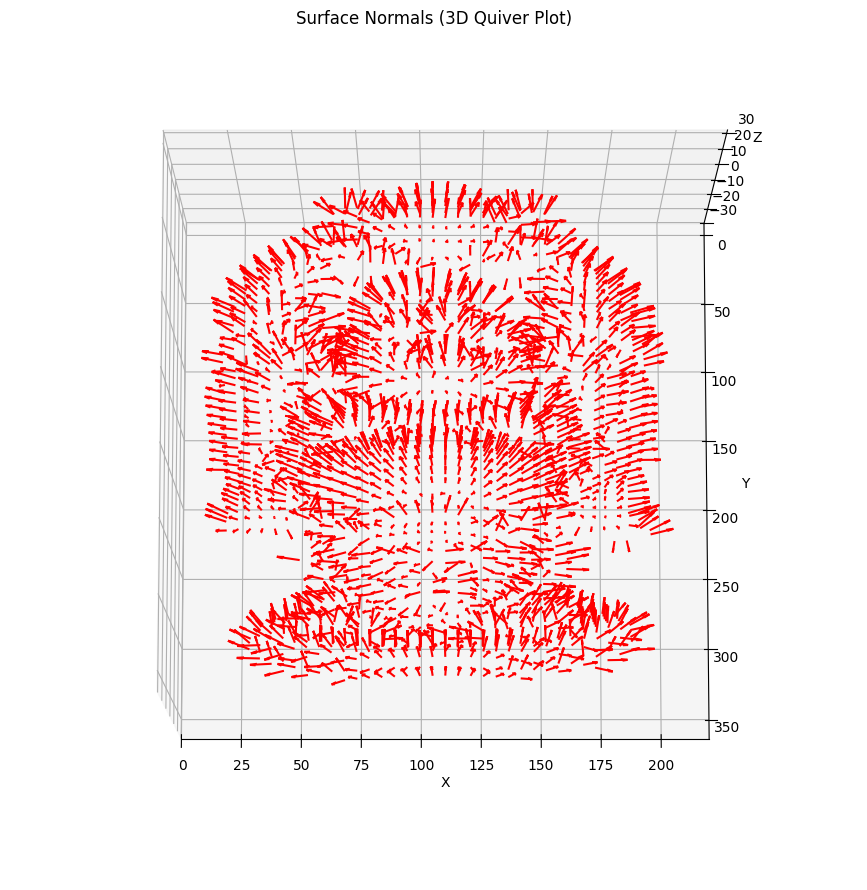

Saved mesh: ./shagoto_predicted_mesh/Buddha_SDPS.ply


In [20]:
import os
import cv2
import numpy as np
import open3d as o3d
from numpy.fft import fft2, ifft2

def frankot_chellappa(p, q):
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T

    Px = fft2(p)
    Qy = fft2(q)

    denom = (2 * np.pi * wx) ** 2 + (2 * np.pi * wy) ** 2
    denom[0, 0] = 1  

    Z = (-1j*2*np.pi*wx * Px - 1j*2*np.pi*wy * Qy) / denom
    return np.real(ifft2(Z))

def depth_from_normals(normals):
    # normals: [H, W, 3], values in [-1,1]
    nz = normals[:, :, 2].copy()
    nz[nz == 0] = 1e-6  # avoid div0

    p = -normals[:, :, 0] / nz
    q = -normals[:, :, 1] / nz
    return frankot_chellappa(p, q)

def save_mesh(depth, normals, out_ply):
    h, w = depth.shape
    # Create XY grid
    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    pts = np.stack([xx, yy, depth], axis=-1).reshape(-1, 3)
    norms = normals.reshape(-1, 3)

    mag = np.linalg.norm(norms, axis=1)
    mask = mag > 1e-3

    verts  = pts[mask]
    normals = norms[mask]

    pcd = o3d.geometry.PointCloud(
        o3d.utility.Vector3dVector(verts)
    )
    pcd.normals = o3d.utility.Vector3dVector(normals)
    pcd.estimate_normals()
    pcd.orient_normals_consistent_tangent_plane(10)

    # Ball Pivoting
    dists = np.asarray(pcd.compute_nearest_neighbor_distance())
    avg   = dists.mean()
    radii = [avg*2, avg*4]
    mesh  = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector(radii)
    )
    o3d.io.write_triangle_mesh(out_ply, mesh)
    print(f"Saved mesh: {out_ply}")

if __name__ == "__main__":
    normal_npy = "./shagoto_predicted_normal/normal_shagoto5.npy"
    out_ply    = "./shagoto_predicted_mesh/Buddha_SDPS.ply"

    # ---- Load normals ----
    normals = np.load(normal_npy)  # shape [3,H,W] or [H,W,3]
    if normals.ndim == 3 and normals.shape[0] == 3:
        normals = normals.transpose(1,2,0)  # -> [H,W,3]
    normals = normals.astype(np.float32)

    normals[:, :, 1] *= -1
    normals[:, :, 2] *= -1


    # ---- Integrate depth ----
    depth = depth_from_normals(normals)

    # Extract height and width
    mask_path = os.path.join("./data/datasets/DiLiGenT/pmsData_crop/buddhaPNG/", "mask.png")
    mask = cv2.imread(mask_path, 0)
    mask = (mask > 0)  
    H, W = depth.shape
    normal_map=normals
    # Extract normals
    Nx = normal_map[:, :, 0]
    Ny = normal_map[:, :, 1]
    Nz = normal_map[:, :, 2]
    
    # Create grid of (X,Y) pixel coordinates
    X_coords = np.arange(W)
    Y_coords = np.arange(H)
    X, Y = np.meshgrid(X_coords, Y_coords)
    
    # Downsample for clarity
    step = 5  
    X_plot = X[::step, ::step]
    Y_plot = Y[::step, ::step]
    Z_plot = depth[::step, ::step]
    Nx_plot = Nx[::step, ::step]
    Ny_plot = Ny[::step, ::step]
    Nz_plot = Nz[::step, ::step]
    
    Z_plot = -Z_plot
    Nz_plot = -Nz_plot
    
    mask_small = mask[::step, ::step]
    X_plot = X_plot[mask_small]
    Y_plot = Y_plot[mask_small]
    Z_plot = Z_plot[mask_small]
    Nx_plot = Nx_plot[mask_small]
    Ny_plot = Ny_plot[mask_small]
    Nz_plot = Nz_plot[mask_small]
    
    # Create 3D quiver plot
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(X_plot, Y_plot, Z_plot, Nx_plot, Ny_plot, Nz_plot,
              length=10.0, normalize=True, color='r')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Surface Normals (3D Quiver Plot)')
    ax.view_init(elev=80, azim=90)
    ax.set_xlim(220, 0) 
    plt.tight_layout()
    plt.show()

    save_mesh(depth, normals, out_ply)


#### For Color

In [21]:
import os
import numpy as np
import cv2
import open3d as o3d
from numpy.fft import fft2, ifft2

def frankot_chellappa(p, q):
    h, w = p.shape
    wx = np.tile(np.fft.fftfreq(w), (h, 1))
    wy = np.tile(np.fft.fftfreq(h), (w, 1)).T
    Px, Qy = fft2(p), fft2(q)
    denom = (2*np.pi*wx)**2 + (2*np.pi*wy)**2
    denom[0,0] = 1
    Z = (-1j*2*np.pi*wx*Px - 1j*2*np.pi*wy*Qy) / denom
    return np.real(ifft2(Z))

def depth_from_normals(normals):
    nz = normals[:,:,2].copy()
    nz[nz==0] = 1e-6
    p = -normals[:,:,0]/nz
    q = -normals[:,:,1]/nz
    return frankot_chellappa(p, q)

def mesh_with_color(normal_npy, color_img_path, out_ply):
    # 1) load normals
    normals = np.load(normal_npy)  # [3,H,W] or [H,W,3]
    if normals.ndim==3 and normals.shape[0]==3:
        normals = normals.transpose(1,2,0)
    normals = normals.astype(np.float32)

    normals[:, :, 1] *= -1
    normals[:, :, 2] *= -1

    depth = depth_from_normals(normals)

    color = cv2.imread(color_img_path, cv2.IMREAD_COLOR)
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB).astype(np.float32)/255.0
    h,w,_ = color.shape

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    pts = np.stack([xx, yy, depth], axis=-1).reshape(-1,3)
    norms = normals.reshape(-1,3)
    cols  = color.reshape(-1,3)

    mask = np.linalg.norm(norms,axis=1)>1e-3
    pts, norms, cols = pts[mask], norms[mask], cols[mask]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pts)
    pcd.normals= o3d.utility.Vector3dVector(norms)
    pcd.colors = o3d.utility.Vector3dVector(cols)

    pcd.estimate_normals()
    dists = np.asarray(pcd.compute_nearest_neighbor_distance())
    avg   = dists.mean()
    radii = [avg*2, avg*4]
    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
        pcd, o3d.utility.DoubleVector(radii)
    )

    # 6) transfer colors from pcd → mesh vertices via nearest‐neighbor
    pcd_tree = o3d.geometry.KDTreeFlann(pcd)
    mesh_vert = np.asarray(mesh.vertices)
    mesh_colors = []
    for v in mesh_vert:
        _, idx, _ = pcd_tree.search_knn_vector_3d(v, 1)
        mesh_colors.append(np.asarray(pcd.colors)[idx[0]])
    mesh.vertex_colors = o3d.utility.Vector3dVector(np.vstack(mesh_colors))

    # 7) save
    os.makedirs(os.path.dirname(out_ply), exist_ok=True)
    o3d.io.write_triangle_mesh(out_ply, mesh)
    print(f"Saved colored mesh to {out_ply}")

if __name__ == "__main__":
    color_img = "./data/datasets/DiLiGenT/pmsData_crop/buddhaPNG/001.png"
    mesh_with_color(
      normal_npy = "./shagoto_predicted_normal/normal_shagoto5.npy",
      color_img_path = color_img,
      out_ply = "./shagoto_predicted_mesh/buddha_colored_SDPS.ply"
    )


Saved colored mesh to ./shagoto_predicted_mesh/buddha_colored_SDPS.ply


#### Angular Error

In [22]:
import scipy.io
import numpy as np
import os


normal_gt_path = os.path.join("./data/datasets/DiLiGenT/pmsData_crop/buddhaPNG/", "Normal_gt.mat")
mat = scipy.io.loadmat(normal_gt_path)
normal_gt = mat['Normal_gt'] 

normal_gt[:, :, 1] *= -1
normal_gt[:, :, 2] *= -1

norm_pred = normal_map / (np.linalg.norm(normal_map, axis=2, keepdims=True) + 1e-6)
norm_gt = normal_gt / (np.linalg.norm(normal_gt, axis=2, keepdims=True) + 1e-6)

dot_product = np.sum(norm_pred * norm_gt, axis=2)
dot_product = np.clip(dot_product, -1.0, 1.0)  # Clamp for safety

angular_error = np.arccos(dot_product) * (180.0 / np.pi)

angular_error[~mask] = np.nan

mean_angular_error = np.nanmean(angular_error)
print(f"Mean Angular Error: {mean_angular_error:.2f} degrees")


Mean Angular Error: 8.98 degrees


#### Mesh
![Mesh Animation.gif](./shagoto_predicted_mesh/ImageToStl.com_Buddha_SDPS+(1).ply.gif)


#### Mesh Color
![Mesh Animation.gif](./shagoto_predicted_mesh/ImageToStl.com_buddha_colored_SDPS.ply.gif)
